In [266]:
from openslide import OpenSlide
import openslide
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import glob
from modules import single_sampler, utils
import pandas as pd
from skimage import filters


In [267]:
from keras.models import load_model
model = load_model('modelVGG16_3Sunday.h5')

In [2]:
file1='1.scn'
file2='2.scn'
file3='3.scn'
file4='4.scn'
file5='5.scn'

In [3]:
img_one = OpenSlide(file1)
img_two = OpenSlide(file2)
img_three = OpenSlide(file3)
img_four = OpenSlide(file4)
img_five = OpenSlide(file5)

In [4]:
img_one1=img_one.read_region(location=(31600,156000),level=3,size=(1000,500))
img_one2=img_one.read_region(location=(59600,156000),level=3,size=(1000,1000))
img_one3=img_one.read_region(location=(31600,185000),level=3,size=(1000,1000))
img_one4=img_one.read_region(location=(59600,185000),level=3,size=(1000,1000))

In [5]:
img_three1=img_three.read_region(location=(32600,124000),level=3,size=(1000,500))
img_three2=img_three.read_region(location=(70900,124000),level=3,size=(1000,1000))
img_three3=img_three.read_region(location=(32600,160000),level=3,size=(1000,1000))
img_three4=img_three.read_region(location=(70600,160000),level=3,size=(1000,1000))

In [271]:
tile=img_one.read_region(location=(33800,165000),level=0,size=(256,256))
t=np.array(tile)
t=t[:,:,0:3]
s=t.reshape(1,256,256,3)
p=model.predict(s)
p

array([[0., 1.]], dtype=float32)

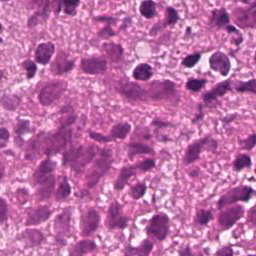

In [262]:
tile

In [7]:
img1_x1=31600
img1_x2=59600
img1_y2=185000
img1_y1=156000
img1_width_tiles=int((img1_x2-img1_x1)/256)
img1_length_tiles=int((img1_y2-img1_y1)/256)
img1_total_tiles=img1_width_tiles*img1_length_tiles

img3_x1=32600
img3_x2=70900
img3_y2=160000
img3_y1=124000
img3_width_tiles=int((img3_x2-img3_x1)/256)
img3_length_tiles=int((img3_y2-img3_y1)/256)
img3_total_tiles=img3_width_tiles*img3_length_tiles

In [269]:
%%time
#coordinates of all tiles x1 =31600, y1=156000

x1=img3_x1
y1=img3_y1

a=img3_width_tiles #no of columns
b=img3_length_tiles #no of rows 

x=np.zeros(a)
y=np.zeros(b)

for i in range(a):
    x[i]=x1
    x1=x[i]+256
    
for i in range(b):
    y[i]=y1
    y1=y[i]+256
    
x=x.astype(int)
y=y.astype(int)
    
predvgg = np.zeros((b,a))

#tiles3=[]

for j in range(b):
    for i in range(a):
        tile=img_three.read_region(location=(x[i],y[j]),level=0,size=(256,256))
        t=np.array(tile)
        t=t[:,:,0:3]
        ots=filters.threshold_otsu(t)
        if(ots>180):
            predvgg[j][i]=2.0
        #tiles3.append(t)
        else:
            s=t.reshape(1,256,256,3)
            p=model.predict(s)
            predvgg[j][i]=np.argmax(p)

/home/samuel/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:271: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (256, 256, 3) looks like an RGB image
  warn(msg.format(image.shape))


CPU times: user 14h 33min 54s, sys: 17min 31s, total: 14h 51min 25s
Wall time: 2h 2min 3s


In [310]:
img3_pred=np.load("Prediction_image3.npy")

In [311]:
img3_pred[np.where(img3_pred == 0)]=5

In [312]:
img3_pred[np.where(img3_pred == 3)]=0

In [313]:
img3_pred[np.where(img3_pred == 2)]=0

In [314]:
img3_pred[np.where(img3_pred == 1)]=0

In [315]:
img3_pred[np.where(img3_pred == 4)]=1

In [316]:
img3_pred[np.where(img3_pred == 5)]=2

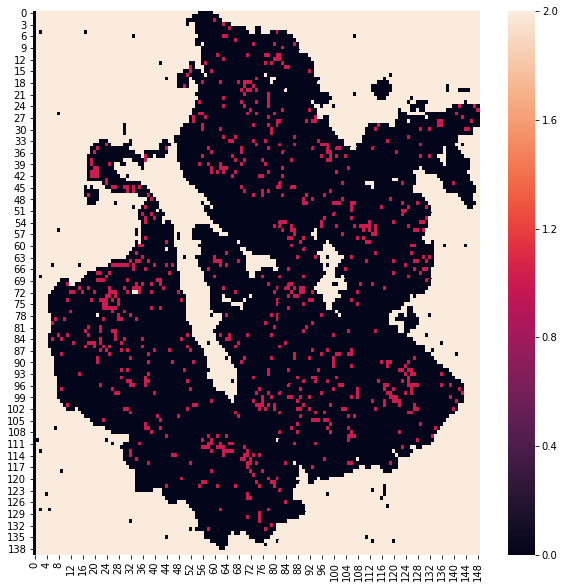

In [317]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax = sns.heatmap(img3_pred)

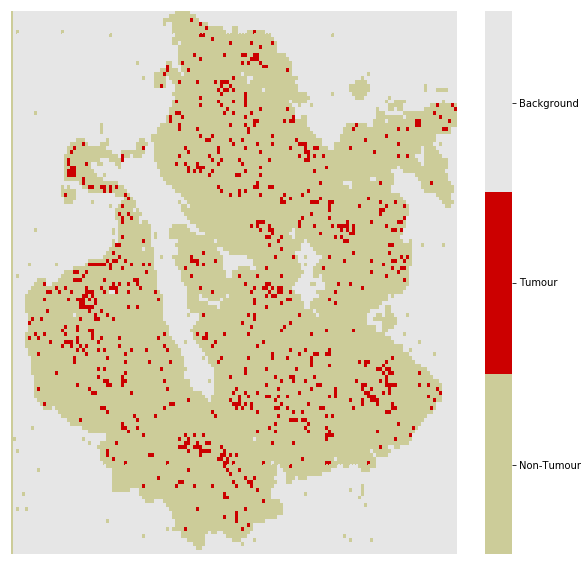

In [318]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(10,10))
myColors = ((0.8, 0.8, 0.6, 1), (0.8, 0.0, 0.0, 1), (0.9, 0.9, 0.9, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
ax = sns.heatmap(img3_pred,cmap=cmap,xticklabels=False,yticklabels=False,cbar=True)
cbar=ax.collections[0].colorbar
cbar.set_ticks([0.33,1,1.66])
cbar.set_ticklabels(['Non-Tumour','Tumour','Background'])
plt.savefig('/home/samuel/Desktop/predvgg.png')

In [10]:
import cv2
import os

path = '/home/samuel/Documents/warwickMathSys/Research_Study_Group/images/scn3_all_tiles'

for i in range(len(tiles3)):
    j=i+1
    cv2.imwrite(os.path.join(path , 'data%i.png' %j), cv2.cvtColor(tiles3[i], cv2.COLOR_RGB2BGR))

In [11]:
print(len(tiles3))


20860


In [12]:
img3_total_tiles

20860

In [167]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [244]:
reg3=np.load('OutputMN2/MNregularFV3.pkl')
tum3=np.load('OutputMN2/MNtumorFV3.pkl')
reg1=np.load('OutputMN2/regularFV1.pkl')
tum1=np.load('OutputMN2/tumorFV1.pkl')
nonroi1=np.load('OutputMN2/nonroi1v452.pkl')

In [249]:
# Creating labels for data

t1=np.ones(len(tum1))
r1=np.zeros(len(reg1))
n1=np.zeros(len(nonroi1))
labels1=np.concatenate((t1,r1,n1),0)

t3=np.ones(len(tum3))
r3=np.zeros(len(reg3))
labels3=np.concatenate((t3,r3),0)
labels3.shape

(2018,)

In [246]:
FV3=np.concatenate((tum3,reg3),0)
FV1=np.concatenate((tum1,reg1,nonroi1),0)
print(FV3.shape)
print(FV1.shape)

(2018, 74)
(2818, 74)


In [255]:
len(t3)

919

In [250]:
# splits a set of data into two sets 
#Train1,Test1,Labels1p1,Labels1p2=train_test_split(FV1,labels1,test_size=0.40)

svclassifier=SVC(kernel='linear')
svclassifier.fit(FV3,labels3)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
Pred1=svclassifier.predict(Test1)
print(classification_report(Pred1,Labels1p2))

             precision    recall  f1-score   support

        0.0       0.80      0.81      0.81       389
        1.0       0.94      0.87      0.90       598
        2.0       0.75      0.96      0.84       141

avg / total       0.87      0.86      0.86      1128



In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [175]:
#  X, y = make_classification(n_samples=1000, n_features=4,
# ...                            n_informative=2, n_redundant=0,
# ...                            random_state=0, shuffle=False)
rfclassifier = RandomForestClassifier(max_depth=2, random_state=0)
#clf.fit(X, y)

In [251]:
rfclassifier.fit(FV3,labels3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [42]:
Pred2=rfclassifier.predict(Test1)
print(classification_report(Pred2,Labels1p2))

             precision    recall  f1-score   support

        0.0       0.71      0.77      0.74       365
        1.0       0.93      0.81      0.86       633
        2.0       0.65      0.90      0.75       130

avg / total       0.83      0.81      0.81      1128



In [44]:
len(Pred2)

1128

In [111]:
#nonroi1=np.load('OutputMN2/nonroi1v452.pkl')
all_features=np.load("OutputMN2/FVfor3scn.pkl")

In [46]:
all_features.shape

(20860, 74)

In [136]:
x=all_features[146]
x

array([ 3.15619076e-01,  6.06180281e-04, -8.65857701e-01,  1.17381605e+01,
       -6.37060411e-07,  1.38034766e-07, -2.74459168e-08,  5.82787855e-09,
       -1.23065896e-09,  2.65519549e-10, -5.75747354e-11,  8.68001736e-02,
        7.20496033e-04,  1.57019063e-02,  6.46424176e-04,  8.37931676e-02,
        3.20540641e-02,  5.59374829e-04,  6.09448920e-04,  2.72734944e-04,
        5.27001054e-04,  1.13475727e-01,  1.15971280e-03,  1.27863513e-03,
        1.49412283e-03,  8.93576787e-02,  8.54361709e-02,  8.42052463e-04,
        6.18798822e-03,  1.47541255e-03,  6.82001364e-04,  1.45064790e-01,
        1.48122030e-03,  6.30919808e-03,  1.18793617e-03,  8.50486701e-02,
        1.02765206e-01,  8.64125231e-04,  2.01964869e-03,  9.11205187e-04,
        2.17000434e-03,  9.45501891e-02,  1.82845789e-03,  9.93611229e-03,
        1.05403726e-03,  5.23901048e-03,  3.10620621e-02,  1.20388741e-01,
        1.88402877e-01,  2.15029008e-02,  2.56439947e-02,  2.73183308e-02,
        2.91052821e-02,  

In [138]:
len(np.nan_to_num(x))

74

In [144]:
a=all_features[1].reshape((1,74))

In [99]:
a.shape

(1, 74)

In [145]:
svclassifier.predict(a)

array([2.])

In [139]:
len(all_features)

20860

In [252]:
%%time
#coordinates of all tiles x1 =31600, y1=156000

x1=img3_x1
y1=img3_y1

a=img3_width_tiles #no of columns
b=img3_length_tiles #no of rows 

x=np.zeros(a)
y=np.zeros(b)

for i in range(a):
    x[i]=x1
    x1=x[i]+256
    
for i in range(b):
    y[i]=y1
    y1=y[i]+256
    
x=x.astype(int)
y=y.astype(int)
    
predsv = np.zeros((b,a))
predrf = np.zeros((b,a))

#tiles3=[]
counter=0

for j in range(b):
    for i in range(a):
        tile=img_three.read_region(location=(x[i],y[j]),level=0,size=(256,256))
        t=np.array(tile)
        t=t[:,:,0:3]
        ots=filters.threshold_otsu(t)
        if(ots>180):
            predsv[j][i]=2.0 #background
            predrf[j][i]=2.0
            counter+=1
        else:
            f=np.nan_to_num(all_features[counter])
            f=f.reshape((1,74))
            predsv[j][i]=svclassifier.predict(f)
            predrf[j][i]=rfclassifier.predict(f)
            counter+=1
#             s=t.reshape(1,256,256,3)
#             p=model.predict(s)
#             pred_image5[j][i]=np.argmax(p)

/home/samuel/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:271: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (256, 256, 3) looks like an RGB image
  warn(msg.format(image.shape))


CPU times: user 2min 4s, sys: 1.88 s, total: 2min 6s
Wall time: 2min 6s


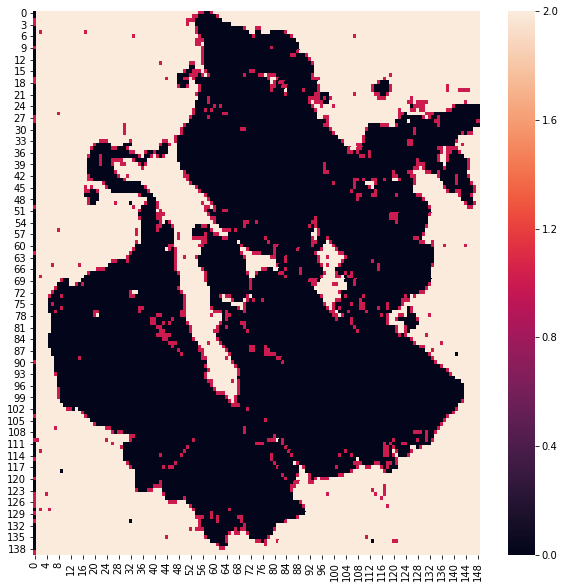

In [253]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax = sns.heatmap(predsv)

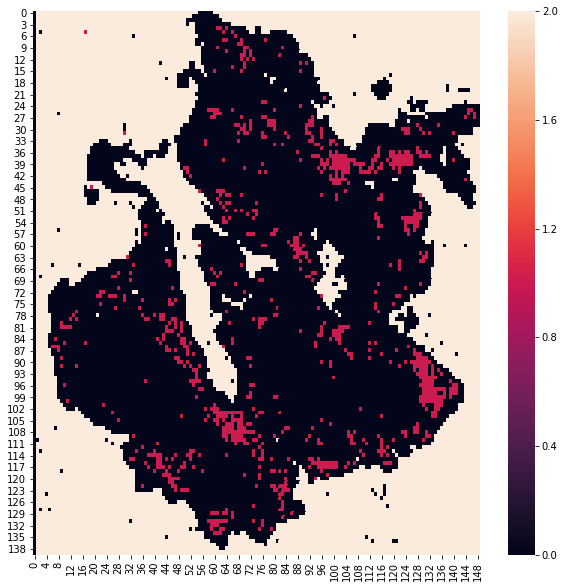

In [254]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax = sns.heatmap(predrf)

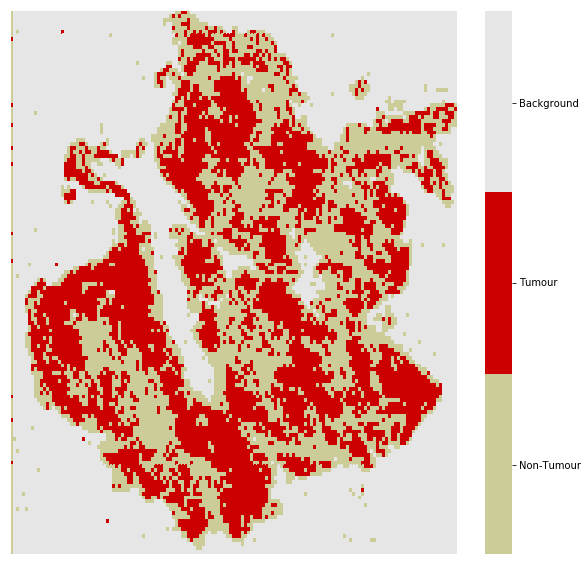

In [235]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(10,10))
myColors = ((0.8, 0.8, 0.6, 1), (0.8, 0.0, 0.0, 1), (0.9, 0.9, 0.9, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
ax = sns.heatmap(predsv,cmap=cmap,xticklabels=False,yticklabels=False,cbar=True)
cbar=ax.collections[0].colorbar
cbar.set_ticks([0.33,1,1.66])
cbar.set_ticklabels(['Non-Tumour','Tumour','Background'])
plt.savefig('/home/samuel/Desktop/predsv.png')

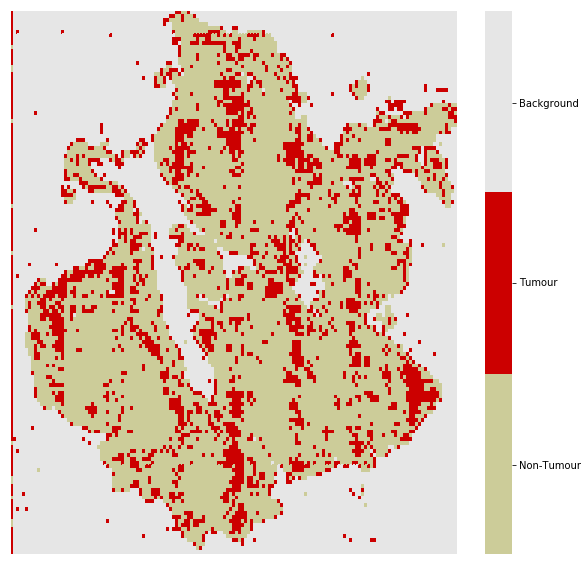

In [236]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.figure(figsize=(10,10))
myColors = ((0.8, 0.8, 0.6, 1), (0.8, 0.0, 0.0, 1), (0.9, 0.9, 0.9, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
ax = sns.heatmap(predrf,cmap=cmap,xticklabels=False,yticklabels=False,cbar=True)
cbar=ax.collections[0].colorbar
cbar.set_ticks([0.33,1,1.66])
cbar.set_ticklabels(['Non-Tumour','Tumour','Background'])
plt.savefig('/home/samuel/Desktop/predrf.png')